In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout

In [3]:
ask_data = pd.read_csv('XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv')
bid_data = pd.read_csv('XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv')


In [4]:
ask_data['Time (UTC)'] = pd.to_datetime(ask_data['Time (UTC)'])
bid_data['Time (UTC)'] = pd.to_datetime(bid_data['Time (UTC)'])

# Step 3: Merge datasets on 'Time (UTC)'
merged_data = pd.merge(ask_data, bid_data, on='Time (UTC)', suffixes=('_Ask', '_Bid'))

# Step 4: Select relevant columns (High and Low prices)
merged_data = merged_data[['Time (UTC)', 'High_Ask', 'Low_Ask', 'High_Bid', 'Low_Bid']]


In [5]:

# Step 4: Normalize data
scaler = MinMaxScaler()
merged_data[['High_Ask', 'Low_Ask', 'High_Bid', 'Low_Bid']] = scaler.fit_transform(
    merged_data[['High_Ask', 'Low_Ask', 'High_Bid', 'Low_Bid']]
)

In [6]:
time_steps = 10  # Look-back period (10 minutes)
prediction_window = 5  # 5-minute prediction window

# Use lists to collect samples incrementally
X, y = [], []

# Select only the required columns
features = merged_data[['High_Ask', 'Low_Ask', 'High_Bid', 'Low_Bid']].values



In [7]:
for i in range(len(features) - time_steps - prediction_window):
    # Extract input sequence for the look-back period
    X_sample = features[i:i+time_steps]
    # Extract the target as the mean over the prediction window
    y_sample = features[i+time_steps:i+time_steps+prediction_window].mean(axis=0)
    X.append(X_sample)
    y.append(y_sample)

# Convert lists to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [13]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dense(units=y.shape[1], activation='linear')  # Output layer
])


2024-12-09 14:42:28.324339: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 14:42:28.324670: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)


Train on 28164 samples, validate on 7041 samples
Epoch 1/50
28164/28164 [==============================] - 6s 227us/sample - loss: 0.0046 - mae: 0.0313 - val_loss: 0.0030 - val_mae: 0.0487
Epoch 2/50
28164/28164 [==============================] - 6s 201us/sample - loss: 4.0274e-04 - mae: 0.0149 - val_loss: 0.0022 - val_mae: 0.0407
Epoch 3/50
28164/28164 [==============================] - 5s 180us/sample - loss: 2.5441e-04 - mae: 0.0119 - val_loss: 0.0051 - val_mae: 0.0639
Epoch 4/50
28164/28164 [==============================] - 5s 172us/sample - loss: 1.7813e-04 - mae: 0.0099 - val_loss: 0.0067 - val_mae: 0.0742
Epoch 5/50
28164/28164 [==============================] - 5s 171us/sample - loss: 1.5021e-04 - mae: 0.0091 - val_loss: 0.0069 - val_mae: 0.0745
Epoch 6/50
28164/28164 [==============================] - 5s 173us/sample - loss: 1.3222e-04 - mae: 0.0084 - val_loss: 0.0071 - val_mae: 0.0773
Epoch 7/50
28164/28164 [==============================] - 5s 175us/sample - loss: 1.2194e-0

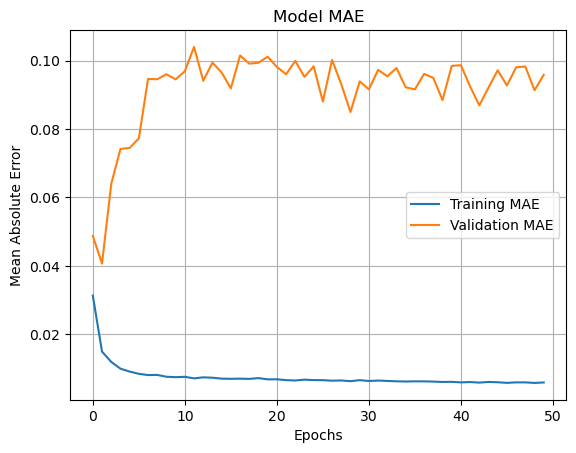

In [15]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.show()
